In [1]:
import torch
import csv
import torchvision
import torchvision.transforms as transforms
import numpy as np
from torch.utils.data.sampler import SubsetRandomSampler
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)
torchvision.__version__


cuda:0


'0.7.0'

In [2]:
# normalise pixel values (range:-1 to 1, mean:0.5, s.d:0.5)
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size=32

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)


# obtain training indices that will be used for validation
num_train = len(trainset)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(0.2 * num_train))
train_idx, valid_idx = indices[split:], indices[:split]

# define samplers for obtaining training and validation batches
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

# prepare data loaders (combine dataset and sampler)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
    sampler=train_sampler, num_workers=2)
validloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
    sampler=valid_sampler, num_workers=2)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
    num_workers=2)


classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


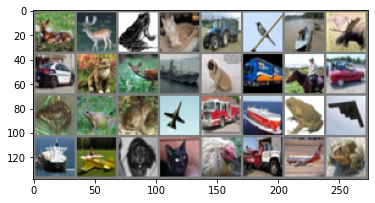

deer  deer  frog  cat   truck bird  ship  deer  car   cat   deer  ship  dog   truck horse car   frog  frog  frog  plane truck ship  frog  plane ship  plane dog   cat   bird  truck plane frog 


In [3]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

In [4]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )

        self.classifier = nn.Sequential(
            nn.Linear(256 * 4 * 4, 1024),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(1024, 52),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(52, 10)
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x


net = Net()
net.to(device)

Net(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [5]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
softmax = nn.Softmax(dim=1)

In [6]:
epochs = 100
min_valid_loss = np.inf
train_acc_tracker=[]
valid_acc_tracker=[]

train_loss_tracker=[]
valid_loss_tracker=[]

for e in range(epochs):
    train_loss = 0.0
    correct_train = 0
    total_train = 0

    for i, data in enumerate(trainloader,0):
        # transfer data to GPU
        net.to(device)
        net.train()
        inputs, labels = data[0].to(device), data[1].to(device)
        # clear gradients
        optimizer.zero_grad()
        # forward Pass
        outputs = net(inputs)
        # find the Loss
        loss = criterion(outputs,labels)
        # calculate gradients
        loss.backward()
        # update Weights
        optimizer.step()
        # calculate Loss
        train_loss += loss.item()
        _, predicted = torch.max(outputs.data,1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    train_accuracy = 100* (correct_train / total_train)

    valid_loss = 0.0
    correct_val = 0
    total_val = 0
    net.eval()
    with torch.no_grad():
        # load validation set
        for i, data in enumerate(validloader, 0):
            # transfer to GPU
            inputs, labels = data[0].to(device), data[1].to(device)
            # forward Pass
            outputs = net(inputs)
            # find the Loss
            loss = criterion(outputs,labels)
            # calculate Loss
            valid_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

    val_accuracy = 100* (correct_val / total_val)

    print(f'Epoch {e+1} \t\t Training Loss: {train_loss / len(trainloader)} \t\t Validation Loss: {valid_loss / len(validloader)}')
    print(f'Epoch {e+1} \t\t Training Acc: {train_accuracy} \t\t Validation Acc: {val_accuracy}')

    if min_valid_loss > valid_loss:
        print(f'Validation Loss Decreased({min_valid_loss:.6f}--->{valid_loss:.6f}) \t Saving The Model')
        min_valid_loss = valid_loss

        # save state
        torch.save(net.state_dict(), 'saved_model.pth')

    train_acc_tracker.append(train_accuracy)
    valid_acc_tracker.append(val_accuracy)

    train_loss_tracker.append(train_loss / len(trainloader))
    valid_loss_tracker.append(valid_loss / len(validloader))

Epoch 1 		 Training Loss: 2.3038489818573 		 Validation Loss: 2.3028078505787226
Epoch 1 		 Training Acc: 9.915000000000001 		 Validation Acc: 9.81
Validation Loss Decreased(inf--->720.778857) 	 Saving The Model
Epoch 2 		 Training Loss: 2.3028873315811156 		 Validation Loss: 2.3028301743272777
Epoch 2 		 Training Acc: 9.7925 		 Validation Acc: 9.81
Epoch 3 		 Training Loss: 2.3027014879226684 		 Validation Loss: 2.3029616975936644
Epoch 3 		 Training Acc: 10.032499999999999 		 Validation Acc: 9.29
Epoch 4 		 Training Loss: 2.3026291706085207 		 Validation Loss: 2.302716990248464
Epoch 4 		 Training Acc: 10.174999999999999 		 Validation Acc: 9.29
Validation Loss Decreased(720.778857--->720.750418) 	 Saving The Model
Epoch 5 		 Training Loss: 2.302722858428955 		 Validation Loss: 2.302791720381179
Epoch 5 		 Training Acc: 10.0025 		 Validation Acc: 9.29
Epoch 6 		 Training Loss: 2.3026291898727416 		 Validation Loss: 2.3028173492358515
Epoch 6 		 Training Acc: 10.12 		 Validation Acc: 9

Epoch 43 		 Training Loss: 0.6710849923491478 		 Validation Loss: 0.6882470002094396
Epoch 43 		 Training Acc: 77.2525 		 Validation Acc: 76.09
Validation Loss Decreased(232.122784--->215.421311) 	 Saving The Model
Epoch 44 		 Training Loss: 0.646018615579605 		 Validation Loss: 0.8280725088744118
Epoch 44 		 Training Acc: 78.1525 		 Validation Acc: 72.39
Epoch 45 		 Training Loss: 0.6173715356945991 		 Validation Loss: 0.6740707499436296
Epoch 45 		 Training Acc: 79.07 		 Validation Acc: 76.8
Validation Loss Decreased(215.421311--->210.984145) 	 Saving The Model
Epoch 46 		 Training Loss: 0.5928564239978791 		 Validation Loss: 0.6636355221271515
Epoch 46 		 Training Acc: 79.875 		 Validation Acc: 77.05
Validation Loss Decreased(210.984145--->207.717918) 	 Saving The Model
Epoch 47 		 Training Loss: 0.5672405424475669 		 Validation Loss: 0.6721101662221427
Epoch 47 		 Training Acc: 80.72500000000001 		 Validation Acc: 77.09
Epoch 48 		 Training Loss: 0.5400731651425361 		 Validation Lo

Epoch 97 		 Training Loss: 0.05695262720393948 		 Validation Loss: 1.221010523029981
Epoch 97 		 Training Acc: 98.265 		 Validation Acc: 81.05
Epoch 98 		 Training Loss: 0.05540159927499481 		 Validation Loss: 1.2284953159193832
Epoch 98 		 Training Acc: 98.2975 		 Validation Acc: 80.91000000000001
Epoch 99 		 Training Loss: 0.0555737122149847 		 Validation Loss: 1.2691155375359349
Epoch 99 		 Training Acc: 98.3 		 Validation Acc: 80.97
Epoch 100 		 Training Loss: 0.05245341563355178 		 Validation Loss: 1.2721536462656415
Epoch 100 		 Training Acc: 98.3725 		 Validation Acc: 80.84


In [9]:
PATH = './val_32_batch_SGD_net.pth'
torch.save(net.state_dict(), PATH)

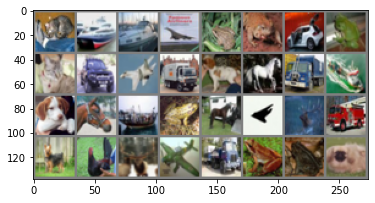

GroundTruth:  cat   ship  ship  plane


In [10]:
dataiter = iter(testloader)
images, labels = next(dataiter)

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(4)))

In [11]:
net = Net()
net.to(device)

net.load_state_dict(torch.load(PATH))

<All keys matched successfully>

In [12]:
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join(f'{classes[predicted[j]]:5s}'
                              for j in range(4)))

Predicted:  car   deer  plane car  


In [13]:
correct = 0
total = 0
# not training so don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in testloader:
        inputs, labels = data[0].to(device), data[1].to(device)
        # calculate outputs by running images through the network
        outputs = net(inputs)
        # the class with the highest energy is choosen as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

Accuracy of the network on the 10000 test images: 78 %


In [14]:
# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# again no gradients needed
with torch.no_grad():
    for data in testloader:
        inputs, labels = data[0].to(device), data[1].to(device)
        outputs = net(inputs)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1

# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

Accuracy for class: plane is 80.3 %
Accuracy for class: car   is 88.6 %
Accuracy for class: bird  is 73.1 %
Accuracy for class: cat   is 50.0 %
Accuracy for class: deer  is 77.6 %
Accuracy for class: dog   is 72.4 %
Accuracy for class: frog  is 86.3 %
Accuracy for class: horse is 83.9 %
Accuracy for class: ship  is 89.5 %
Accuracy for class: truck is 86.9 %


In [15]:
csv_filename = "SDG_training_and_val_log_final.csv"
epochlist= [i for i in range(1, e+1) ]
with open(csv_filename, 'w', newline='') as csv_file:
    csv_writer = csv.writer(csv_file)
    csv_writer.writerow(["nepochs", "train_acc", "train_loss", "val_acc", "val_loss"])
    csv_writer.writerows(zip(epochlist, train_acc_tracker, train_loss_tracker, valid_loss_tracker, valid_acc_tracker))

print(f"Logbook exported to {csv_filename}")

Logbook exported to SDG_training_and_val_log.csv


In [1]:
# plot loss graph
plt.plot(np.arange(0,100), train_loss_tracker, label='Training Loss')
plt.plot(np.arange(0,100), valid_loss_tracker, label='Validation Loss')
plt.title('SGD Loss')
plt.xlabel('No. of epochs')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.savefig('sgd_loss_train_val')
plt.show()

# plot accuracy graph
plt.plot(np.arange(0,100), train_acc_tracker, label='Training Accuracy')
plt.plot(np.arange(0,100), valid_acc_tracker, label='Validation Accuracy')
plt.title('SGD Accuracy')
plt.xlabel('No. of epochs')
plt.ylabel('Accuracy')
plt.legend(loc='upper left')
plt.savefig("sdg_acc_val_train")
plt.show()

NameError: name 'plt' is not defined